### 01-AlexNet

### Imports

In [1]:
import os
import json
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

### Network

In [2]:
class AlexNet(nn.Module):
    
    # Nework to classify 2 classes from COCO dataset
    def __init__(self, class_count=2, dropout=0.5):
        super(AlexNet, self).__init__()
        
        # Define layers (out_channels is number of kernels)    

        # As depicted in Figure 2, the net contains eight layers with weights; the first five are convolutional and the remaining three are fully connected. 
        
        # The first convolutional layer filters the 224x224x3 input image with 96 kernels of size 11x11x3 with a stride of 4 pixels 
        # The second convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.norm1 = nn.BatchNorm2d(96)
        self.relu1 = nn.ReLU(inplace=True)
        # self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # The second convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer 
        # and filters it with 256 kernels of size 5x5x48        
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2) # Padding=2 ensures the spatial dimensions are preserved before pooling
        self.norm2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)
        # self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # The third, fourth, and fifth convolutional layers are connected to one another without any intervening
        # pooling or normalization layers. 
        # The third convolutional layer has 384 kernels of size 3x3x256 connected to the (normalized, pooled) outputs of the second convolutional layer. 
        # The fourth convolutional layer has 384 kernels of size 3x3x192 , and 
        # the fifth convolutional layer has 256 kernels of size 3x3x192.
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=0)        
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=0)
        self.relu4 = nn.ReLU(inplace=True)

        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=0)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1)

        # We use dropout in the first two fully-connected layers of Figure 2. Without dropout, our network exhibits substantial overfitting. 
        # Dropout roughly doubles the number of iterations required to converge
        # The fully-connected layers have 4096 neurons each.
        self.dropout6 = nn.Dropout(p=dropout) # Dropout randomly zeroes out 50% of the neurons to prevent overfitting.
        #IMP: 5 * 5 here will be output size when impage input is 224 x 224, for other image sizes you need to change 5 * 5 with appropriate value
        self.fc6 = nn.Linear(in_features=256 * 5 * 5, out_features=4096) # FC6 is a dense layer with 4096 neurons.        
        self.relu6 = nn.ReLU(inplace=True)

        self.dropout7 = nn.Dropout(p=dropout)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096)
        self.relu7 = nn.ReLU(inplace=True)

        self.fc8 = nn.Linear(in_features=4096, out_features=class_count)
        # Note: Not applying softmax as nn.CrossEntropyLoss() internally applies LogSoftmax
        
    
    def forward(self, x):
        
        # Implement forward pass
        
        x = self.conv1(x)        
        x = self.relu1(x)
        # x = self.norm1(x)
        x = self.pool1(x)        

        x = self.conv2(x)
        x = self.relu2(x)
        # x = self.norm2(x)
        x = self.pool2(x)        

        x = self.conv3(x)
        x = self.relu3(x)        

        x = self.conv4(x)
        x = self.relu4(x)        

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)        

        x = torch.flatten(x, 1) # Flatten all dimensions except the batch. Flatten converts the 3D feature maps into a 1D vector.        
        x = self.dropout6(x)
        x = self.fc6(x)
        x = self.relu6(x)        

        x = self.dropout7(x)
        x = self.fc7(x)
        x = self.relu7(x)        
        
        x = self.fc8(x) # Ouputs logits for number of classes        

        return x

    def get_loss(self, outputs, targets):
        # Cross entropy loss
        return nn.CrossEntropyLoss()(outputs, targets)

    def get_optimizer(self, learning_rate=0.01):
        # SGD with momentum and weight decay
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

### Config

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device:{device}')

device:cuda


In [4]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.0001 #0.005 #0.001 #0.01
batch_size = 32

In [5]:
label_map = {0: 'person', 1: 'bird'}

### Data Pre-processing

In [6]:
# Data preprocessing
normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet expects 227x227 input
    transforms.ToTensor(),
    normalize
])

### Dataset

In [7]:
class ClassficationDatasetCOCO(Dataset):
    
    def __init__(self, image_dir_path, annotation_json_path, image_extension = '.jpg' ,coco_class_names = ['person','bird'] , transform = None):
        
        self.image_dir_path = image_dir_path
        self.coco_class_names = coco_class_names
        self.image_labels = []
        
        # Load image names
        self.image_filenames = [f for f in os.listdir(self.image_dir_path) if f.endswith(image_extension)]
        # print(self.image_filenames)

        # Get image labels
        with open(annotation_json_path, 'r') as f:
            self.annotation_json = json.load(f)

        for image_filename in self.image_filenames:
            
            # print(f'image_filename:{image_filename}')            
            
            for image_item in self.annotation_json["images"]:
                
                if image_item["file_name"] == image_filename:                    
                    image_id = image_item["id"]
                    # print(f'image_id:{image_id}')
                    
                    label_retrieved_flag = False

                    for annotation_item in self.annotation_json["annotations"]:                        
                        
                        if annotation_item["image_id"] == image_id:
                            
                            category_id = annotation_item["category_id"]
                            # print(f'category_id:{category_id}')

                            for category_item in self.annotation_json["categories"]:

                                # Only classes for which we downloaded the COCO images in 00 notebook
                                if category_item["id"] == category_id and category_item["name"] in self.coco_class_names:
                                    category_name = category_item["name"]
                                    # print(f'category_name:{category_name}')
                                    label_index = coco_class_names.index(category_name) # CrossEntropy loss expects labels to be in range [0, num_classes - 1]
                                    self.image_labels.append(label_index) # We need numeric label id for training not label name
                                    
                                    label_retrieved_flag = True
                                    break

                            # Check if class label of interest found as single image has been given multiple labels in COCO annotations json
                            if label_retrieved_flag:
                                break

        self.transform = transform

        print(f'len(image_filenames):{len(self.image_filenames)}')
        print(f'len(image_labels):{len(self.image_labels)}')
        print(f'Dataset metadata loaded')

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir_path, self.image_filenames[idx])).convert('RGB')     
        
        # Apply transform to convert PIL image to tensor
        if self.transform:
            image = self.transform(image)
        
        label = self.image_labels[idx]        
        
        return image, label

In [8]:
%%time

dataset = ClassficationDatasetCOCO(image_dir_path='../datasets/coco_images', 
                                   annotation_json_path = '../datasets/annotations/annotations_trainval2017/annotations/instances_train2017.json',  
                                   image_extension = '.jpg', 
                                   coco_class_names = ['person','bird'], # Only classes for which we downloaded the COCO images in 00 notebook
                                   transform = transform)

len(image_filenames):397
len(image_labels):397
Dataset metadata loaded
CPU times: user 33.7 s, sys: 1.64 s, total: 35.4 s
Wall time: 39.5 s


In [9]:
# Sanity check if dataset is correctly setup and coded
data_loader_train = DataLoader(dataset, batch_size = batch_size, shuffle = True)

for images, labels in data_loader_train:
    print(images.shape)
    print(labels)    
    break

torch.Size([32, 3, 227, 227])
tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0])


### Training

In [10]:
import torch.optim as optim
model = AlexNet(class_count=len(['person','bird']), dropout=0.25).to(device) # Dropout reduced to improve accuracy (paper uses 0.5)
# model = AlexNetPT(num_classes=len(['person','bird'])).to(device)
# optimizer = model.get_optimizer(learning_rate=learning_rate)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate) # Per paper, however loss does not go down by varrying lr, batch_size, so testing Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam does much better job than SGD (Paper mentioned SGD)

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)        
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        # print(f'predicted:{predicted}|labels:{labels}')
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/50] - Loss: 8.9713, Accuracy: 52.64%
Epoch [2/50] - Loss: 9.0595, Accuracy: 50.38%
Epoch [3/50] - Loss: 8.9382, Accuracy: 53.90%
Epoch [4/50] - Loss: 8.9598, Accuracy: 53.90%
Epoch [5/50] - Loss: 9.0019, Accuracy: 53.90%
Epoch [6/50] - Loss: 8.9839, Accuracy: 53.90%
Epoch [7/50] - Loss: 8.9217, Accuracy: 53.90%
Epoch [8/50] - Loss: 8.9403, Accuracy: 53.15%
Epoch [9/50] - Loss: 8.7829, Accuracy: 55.42%
Epoch [10/50] - Loss: 8.8275, Accuracy: 53.15%
Epoch [11/50] - Loss: 8.9176, Accuracy: 57.43%
Epoch [12/50] - Loss: 8.7959, Accuracy: 55.16%
Epoch [13/50] - Loss: 8.5196, Accuracy: 60.20%
Epoch [14/50] - Loss: 8.6310, Accuracy: 64.99%
Epoch [15/50] - Loss: 8.4343, Accuracy: 63.22%
Epoch [16/50] - Loss: 8.8833, Accuracy: 62.72%
Epoch [17/50] - Loss: 8.2985, Accuracy: 62.97%
Epoch [18/50] - Loss: 8.2598, Accuracy: 63.73%
Epoch [19/50] - Loss: 7.7574, Accuracy: 65.99%
Epoch [20/50] - Loss: 6.9075, Accuracy: 75.31%
Epoch [21/50] - Loss: 6.2735, Accuracy: 76.83%
Epoch [22/50] - Loss: 

### Test

Predicted class: bird


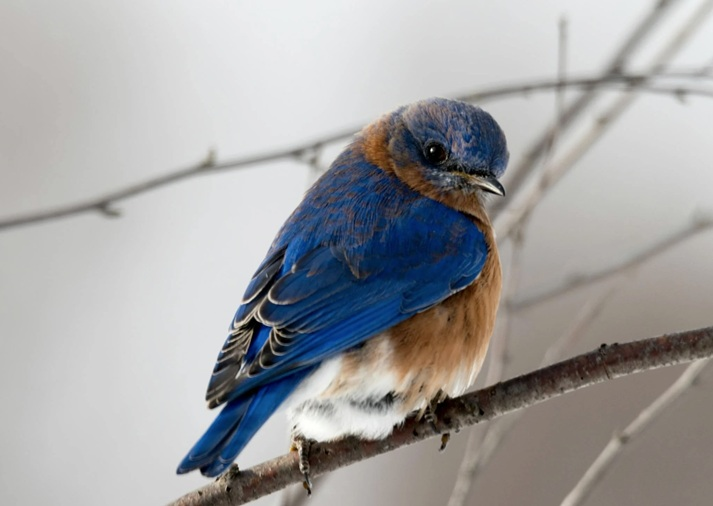

In [18]:
# image_path = '../datasets/coco_images/000000155777.jpg'
image_path = '../datasets/test2.jpg'
image = Image.open(image_path).convert('RGB')
image_to_view = image 
image = transform(image).unsqueeze(0)  # Add batch dimension

# Load model and set to eval mode
model.eval()
image = image.to(device)

# Run prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Map prediction to class name
class_names = ['person', 'bird']  # or use dataset.coco_class_names
print(f"Predicted class: {class_names[predicted.item()]}")
image_to_view

### Miscellaneous

Illustration of 2 layer NN, 1 neuron each, value passing between layers

In [13]:
# Define ReLU activation function  
def relu(x):  
    return max(0, x)  
  
# Define Layer 1 (Single Neuron)  
def layer1(inputs, weights, bias):  
    # Compute weighted sum  
    z1 = sum([w * x for w, x in zip(weights, inputs)]) + bias  
    # Apply ReLU activation function  
    a1 = relu(z1)  
    return a1  
  
# Define Layer 2 (Single Neuron)  
def layer2(inputs, weights, bias):  
    # Compute weighted sum (inputs from Layer 1 output)  
    z2 = sum([w * x for w, x in zip(weights, inputs)]) + bias  
    # Apply ReLU activation function  
    a2 = relu(z2)  
    return a2  
  
# Example inputs, weights, and biases  
inputs = [1.0, 2.0]  # Inputs to Layer 1  
weights1 = [0.5, -1.0]  # Weights for Layer 1  
bias1 = 1.0  # Bias for Layer 1  
  
weights2 = [2.0]  # Weights for Layer 2 (single input from Layer 1)  
bias2 = 0.5  # Bias for Layer 2  
  
# Forward pass  
output_layer1 = layer1(inputs, weights1, bias1)  # Output of Layer 1  
output_layer2 = layer2([output_layer1], weights2, bias2)  # Output of Layer 2  
  
# Print outputs  
print("Output of Layer 1:", output_layer1)  
print("Output of Layer 2:", output_layer2)  

Output of Layer 1: 0
Output of Layer 2: 0.5


Illustration of convolutions, kernels and feature maps

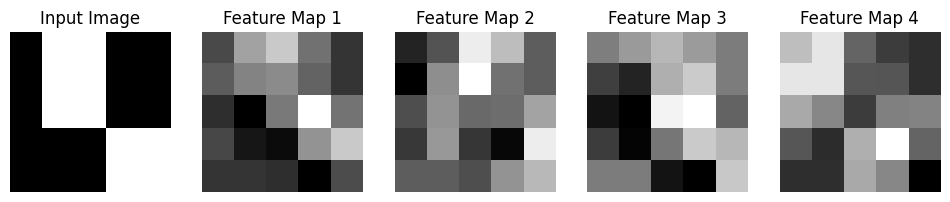

In [14]:
import torch  
import torch.nn as nn  
import matplotlib.pyplot as plt  
import numpy as np  
  
# Create a simple input image (grayscale, 1 channel)  
image = torch.tensor([  
    [0, 1, 1, 0, 0],  
    [0, 1, 1, 0, 0],  
    [0, 1, 1, 0, 0],  
    [0, 0, 0, 1, 1],  
    [0, 0, 0, 1, 1]  
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 5, 5)  
  
# Define a Conv2d layer with multiple kernels (filters)  
conv_layer = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)  
  
# Apply the convolutional layer to the input image  
output = conv_layer(image)  # Shape: (1, 4, 5, 5) -> 4 feature maps  
  
# Visualize the input image and the resulting feature maps  
def visualize_feature_maps(image, feature_maps):  
    # Plot the input image  
    plt.figure(figsize=(12, 6))  
    plt.subplot(1, feature_maps.shape[1] + 1, 1)  
    plt.title("Input Image")  
    plt.imshow(image.squeeze(0).squeeze(0).numpy(), cmap="gray")  
    plt.axis("off")  
      
    # Plot each feature map  
    for i in range(feature_maps.shape[1]):  
        plt.subplot(1, feature_maps.shape[1] + 1, i + 2)  
        plt.title(f"Feature Map {i+1}")  
        plt.imshow(feature_maps.squeeze(0)[i].detach().numpy(), cmap="gray")  
        plt.axis("off")  
      
    plt.show()  
  
visualize_feature_maps(image, output)  